# Step 1: Understand the Data and the Problem

* Read the data
* View the data
* Check the data dimensions
* Check the data type

## Problem

Understand and predict the relationship between medical insurance **charges** (numerical), and the features

1. age (numerical)
2. sex (categorical)
3. bmi (numerical)
4. children (numerical)
5. smoker (categorical)
6. region (categorical)

In [81]:
#loading the libraries

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import warnings
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.tree import plot_tree
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.mixture import GaussianMixture

In [84]:
#reading the file
df = pd.read_csv('/kaggle/input/ushealthinsurancedataset/insurance.csv')

# looking into the dataframe
df.head()
print(df.shape)
df.info()

(1338, 7)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


# Step 2: Univariate Sample Distribution of Data

Univariate Sample Distribution helps one to understand how each feature, and the response variable is distributed. This may give insights into data preprocessing for better model performance, and interpretability. One can use 

* histogram for visualizing numerical feature
* count plot for visualizing categorical feature

## Interpretation

* A monotonic log transform on the charges, since there are large values, which may result in unstable optimization. It is not applied here, and basic analysis is performed without log transformation. But it may be implemented as done in ISLR [1]. However, this may result in unknown interpretation of the prediction.

[[1]](https://www.statlearning.com/) (An Introduction to Statistical Learning with Applications in R: ISLR, Chapter 8, 8.1.1 Regression Trees) We use the Hitters data set to predict a baseball player’s Salary based on Years (the number of years that he has played in the major leagues) and Hits (the number of hits that he made in the previous year). We first remove observations that are missing Salary values, and log-transform Salary so that its distribution has more of a typical bell-shape. (Recall that Salary is measured in thousands of dollars.)

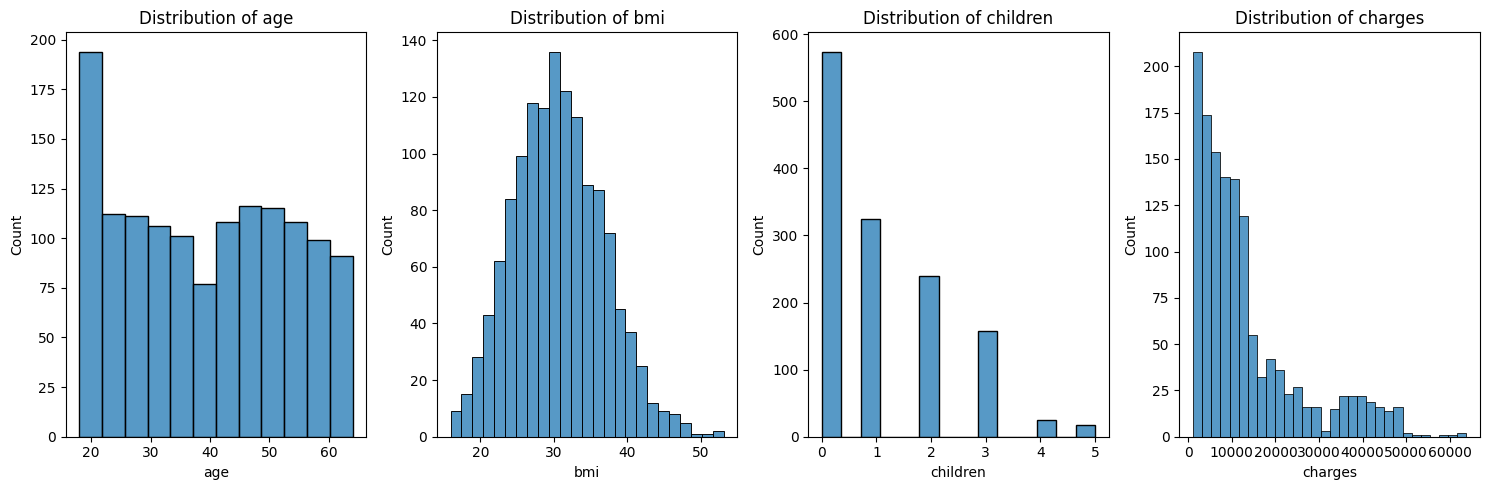

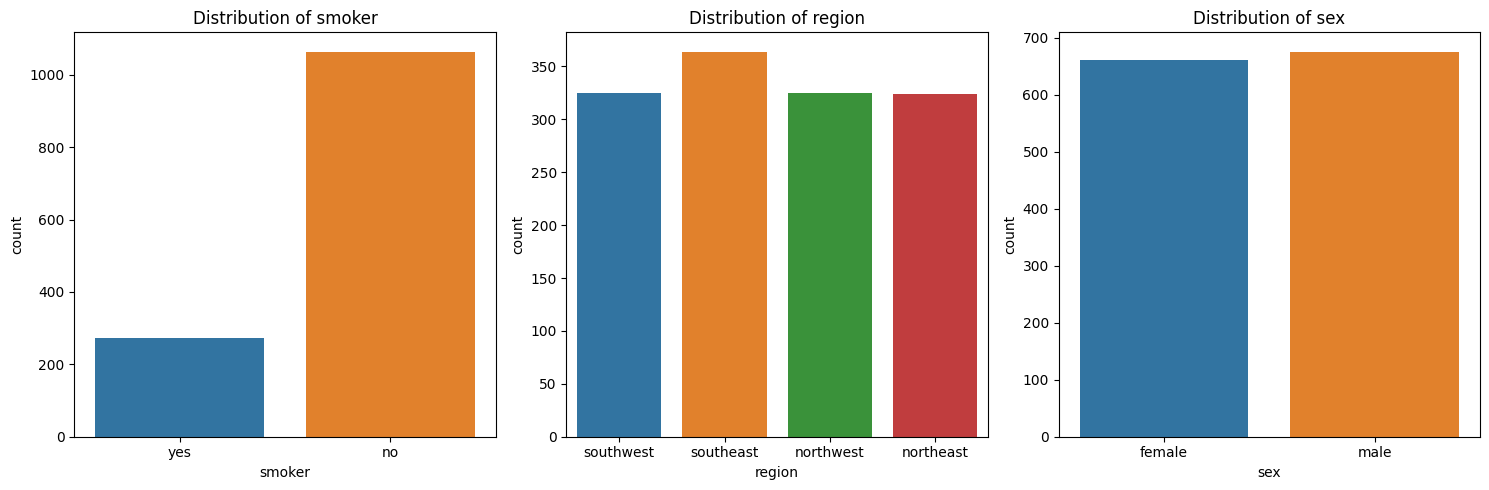

In [4]:
# Suppress the FutureWarning from modules
warnings.filterwarnings("ignore", category=FutureWarning, module="seaborn")

# Numerical features
numerical_features = ['age', 'bmi', 'children', 'charges']
fig, axes = plt.subplots(1, len(numerical_features), figsize=(15, 5))
for i, feature in enumerate(numerical_features):
    sns.histplot(df[feature], ax=axes[i])
    axes[i].set_title(f'Distribution of {feature}')
plt.tight_layout()
plt.show()

# Categorical features
categorical_features = ['smoker', 'region', 'sex']
fig, axes = plt.subplots(1, len(categorical_features), figsize=(15, 5))
for i, feature in enumerate(categorical_features):
    sns.countplot(x=feature, data=df, ax=axes[i])
    axes[i].set_title(f'Distribution of {feature}')
plt.tight_layout()
plt.show()

# Step 3: Bivariate Sample Relationship of Charges with Features

Bivariate Sample Distribution of response variable may help one helps one to understand how the response variable is individually related to each of the feature. This can help us understand visually, which may be the most important variable for prediction. This can also show multivariate relationship, mostly related to the important features discovered.

* In this problem, you will see a beautiful multivariate relationship, which is coming in the next step.

## Interpretation


* scatterplot for visualizing numerical (charges) vs numerical features
* grouped kernel density plot for visualizing numerical (charges) vs categorical features
* the smoker is the most important variable, since the two kernel densities based on smokers and non smokers, are very distinct
* both the scatter plots of charges vs age and bmi individually shows significant relationships
* there seem to be unknown third variable effect leading to distinct behaviours
* both the age and bmi seems to have multiple distinct processes happening behind the scence. the processes seem to be distinct. 
* hence the best guess is to invoke the smoker variable along with age and bmi, because age shows significant predictive relationship from the grouped kernel density plot
* there seem to be a slight increasing till 2-3 children, and then decreasing after that relationship with charges.
* we will look into a multivariate plot of charges with (age, smoker), (bmi, smoker), and (children, smoker) in the next step.
* other features don't seem to have any effect on the charges.



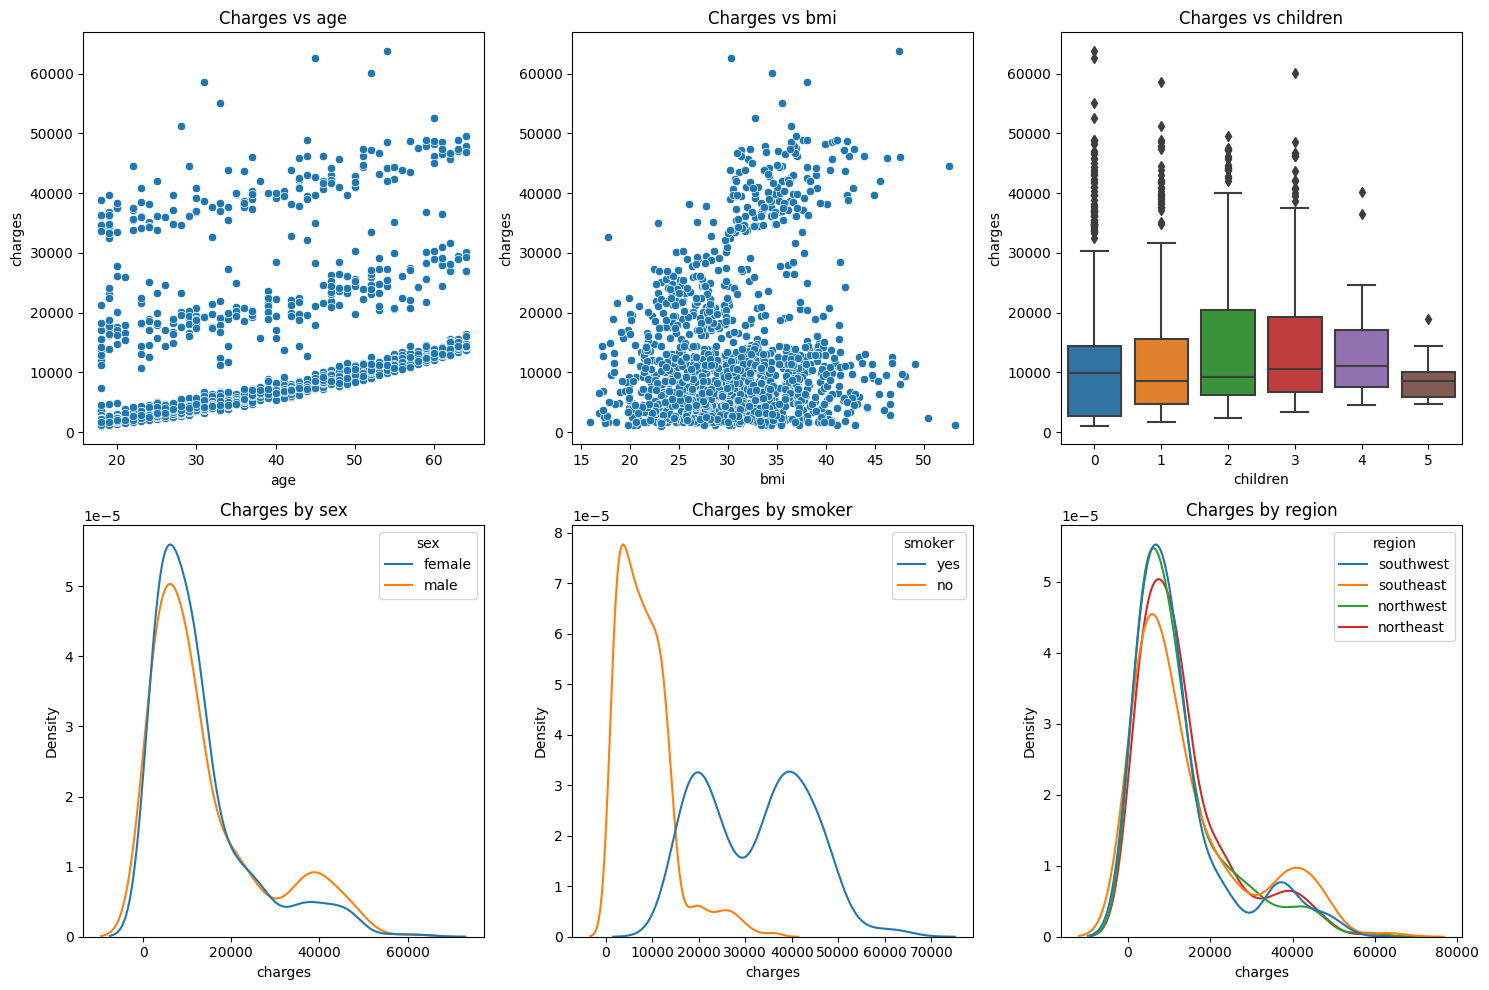

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns

# Numerical features
numerical_features = ['age', 'bmi']

numerical_discrete = ['children']

# Categorical features
categorical_features = ['sex', 'smoker', 'region']

# Create a figure and axes
fig, axes = plt.subplots(2, 3, figsize=(15, 10))

# Iterate over numerical features
for i, num_feature in enumerate(numerical_features):
    # Scatter plots for numerical vs numerical
    sns.scatterplot(x=num_feature, y='charges', data=df, ax=axes[0, i])
    axes[0, i].set_title(f'Charges vs {num_feature}')

for i, num_feature in enumerate(numerical_discrete):
    # Scatter plots for numerical vs numerical
    sns.boxplot(x=num_feature, y='charges', data=df, ax=axes[0, 2])
    axes[0, 2].set_title(f'Charges vs {num_feature}')


# Iterate over categorical features
for i, cat_feature in enumerate(categorical_features):
    # Kernel density plots for numerical vs categorical
    sns.kdeplot(x='charges', hue=cat_feature, data=df, common_norm=False, ax=axes[1, i])
    axes[1, i].set_title(f'Charges by {cat_feature}')

plt.tight_layout()
plt.show()

# Step 4: Sample Relationship of Charges with Features and Smoker (important feature visually)

Since smoker seems to be an important feature for predicting charges and age along with bmi shows important relationship, and segregated clusters of processes inside the individual scatterplots with charges, there seem to be a third variable involved in the scatterplots of age and bmi with charges. I suspec that is smoker. We will understand it based on the multivariate scatter plot of age, bmi, and children with charges, along with the third variable smoker, which colours each point in the scatterplot.

## Interpretation (Visually)

* You can understand that given the **smoker** feature, the other variables show different relationship with charges.
* This is an example of multivariate relationship of the charges response variable with the features. 
* for smoker = yes, charges have similar slope with respect to age visually, as for smoker = no. However, the intercepts may vary. Also, charges vs age relationship have another process going on, which we need to discover.
* Interestly, for smoke = no, bmi shows no relationship, but for smoker = yes, bmi shows a clear increasing relationship, with two different clusters, however inside those clusters, there are no significant relationship between bmi and charges.
* For smoker = no, charges have a slight increasing relationship with children. However, for smoker = yes, charges increases till a certain point (around 2- 3 children), and then again decreases.
* This indeed shows that (smoker, age, bmi, children) together show a strong prediction power and relationship with charges.
* This naturally demands a decision tree, which can help us understand more hidden relationships, and quantify the above visually observed relationships, along with a predictive model.
* In the next steps, we will fit three models: Decision Trees, Random Forests, and Boruta Algorithm with Random Forests to get predictions, and also feature importances, and relationships.

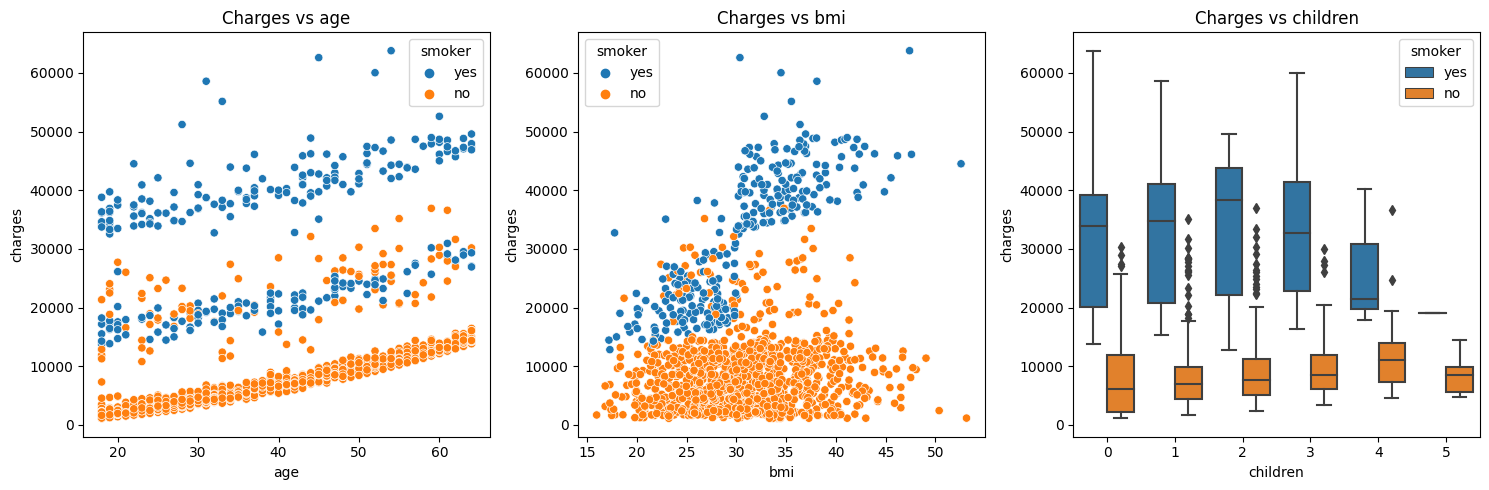

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns

# Numerical features
numerical_features = ['age', 'bmi']

numerical_discrete = ['children']

# Create a figure and axes
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Iterate over numerical features
for i, num_feature in enumerate(numerical_features):
    # Scatter plots for numerical vs numerical, colored by smoker status
    sns.scatterplot(x=num_feature, y='charges', hue='smoker', data=df, ax=axes[i])
    axes[i].set_title(f'Charges vs {num_feature}')

for i, num_feature in enumerate(numerical_discrete):
    # Scatter plots for numerical vs numerical
    sns.boxplot(x=num_feature, y='charges', hue='smoker', data=df, ax=axes[2])
    axes[2].set_title(f'Charges vs {num_feature}')

plt.tight_layout()
plt.show()

# Step 5: Preparing the Dataset for Model Selection

The dataset's categorical features are transformed into numerical format with one-hot encoding, and the rest of the numerical features are kept as it is. Then the dataset is partitioned into 80% training data, and 20% test data. 

**Note**: I am not doing any cross validation here. Ideally, for hyperparameter tuning, there should a train, validation, and test dataset. The best model should be selected based on train-validation performance. The final selected model's performance should be presented on the test dataset. I am not following this procedure in this case.

In [96]:
# Categorical and numerical features
categorical_features = ['sex', 'smoker', 'region']
numerical_features = ['age', 'bmi', 'children']

transformer = ColumnTransformer(
    transformers=[
        ('onehot', OneHotEncoder(), categorical_features)
    ],
    remainder='passthrough'  # Keep numerical features as is
)

# Transform the features
# Features and target variable
X = transformer.fit_transform(df.drop('charges', axis=1))
y = df['charges']

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 6: Decision Tree

I choose three metrics (rmse, mae, $R^2$). The decision tree gives

* train error (rmse) ~ 4198
* test error (rmse) ~4512

In [15]:
# Initialize and fit decision tree model
tree = DecisionTreeRegressor(max_depth=5, min_samples_split=10, min_samples_leaf=5)
tree.fit(X_train, y_train)

# Predict on train data
y_pred_train = tree.predict(X_train)

# Predict on test data
y_pred_test = tree.predict(X_test)

In [17]:
# Evaluate model performance on training data
mse_train = mean_squared_error(y_train, y_pred_train)
rmse_train = mean_squared_error(y_train, y_pred_train, squared=False)
mae_train = mean_absolute_error(y_train, y_pred_train)
r2_train = r2_score(y_train, y_pred_train)

print('Training Metrics:')
print('RMSE:', rmse_train)
print('MAE:', mae_train)
print('R^2:', r2_train)

# Evaluate model performance on testing data
rmse_test = mean_squared_error(y_test, y_pred_test, squared=False)
mae_test = mean_absolute_error(y_test, y_pred_test)
r2_test = r2_score(y_test, y_pred_test)

print('\nTesting Metrics:')
print('RMSE:', rmse_test)
print('MAE:', mae_test)
print('R^2:', r2_test)

Training Metrics:
RMSE: 4198.369141355529
MAE: 2358.8082416905745
R^2: 0.8778780494038285

Testing Metrics:
RMSE: 4512.074159035287
MAE: 2647.2164433863823
R^2: 0.8688632556220739


## Step 6.1: Visualizing the Decision Tree, and their Feature Importance

- 

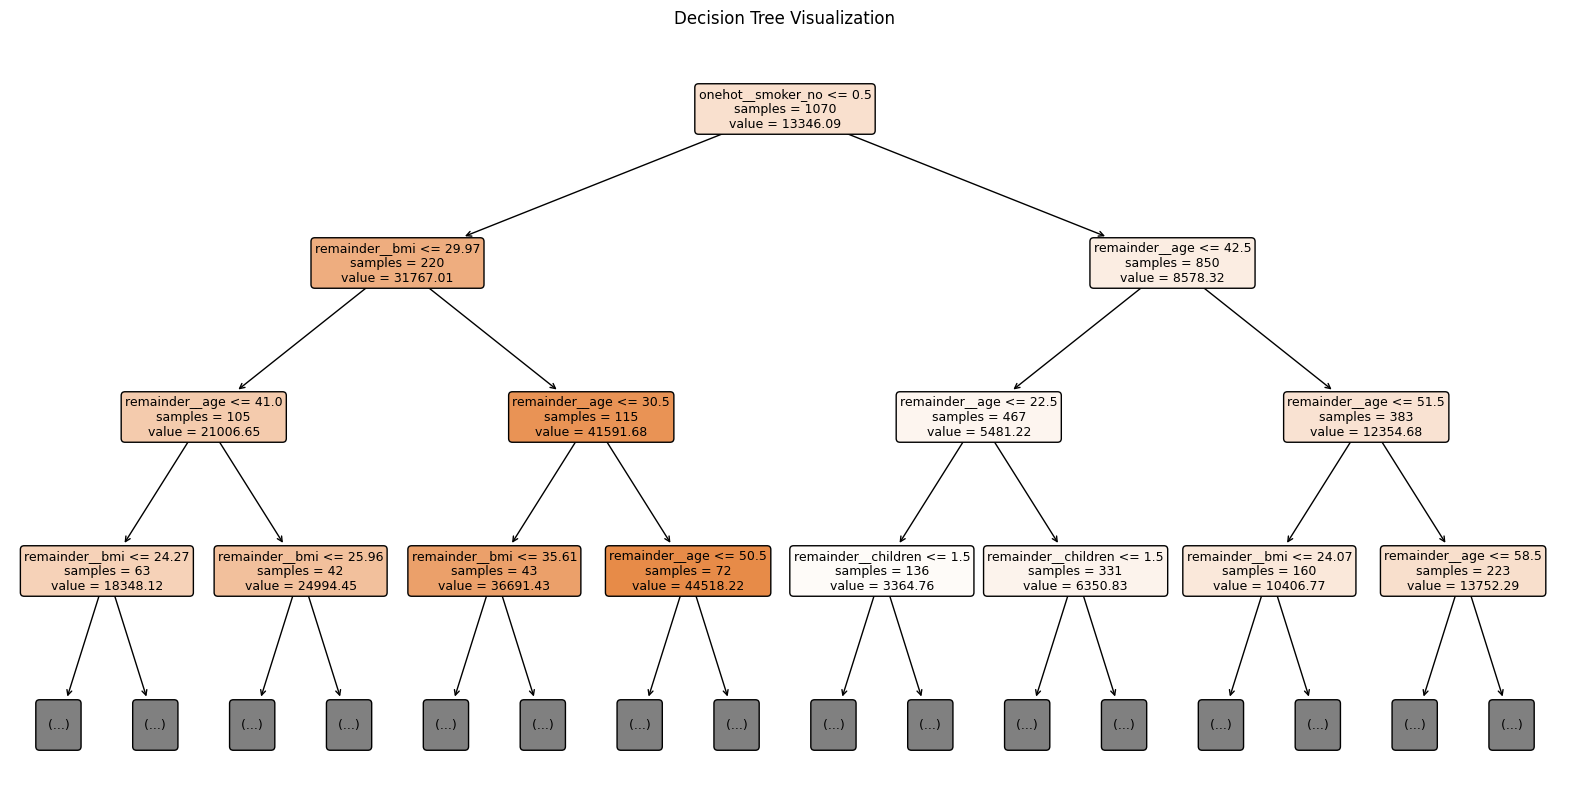

In [53]:
<a id='decision_tree_visualize'></a>

# Assuming 'tree' is your trained model and 'transformer' is your feature transformer
plt.figure(figsize=(20, 10))

# Customize the plot_tree parameters
plot_tree(tree, 
          feature_names=transformer.get_feature_names_out(), 
          filled=True, 
          rounded=True, 
          precision=2, 
          fontsize=9, 
          max_depth=3, 
          proportion=False, 
          impurity=False)

plt.title("Decision Tree Visualization")
plt.show()

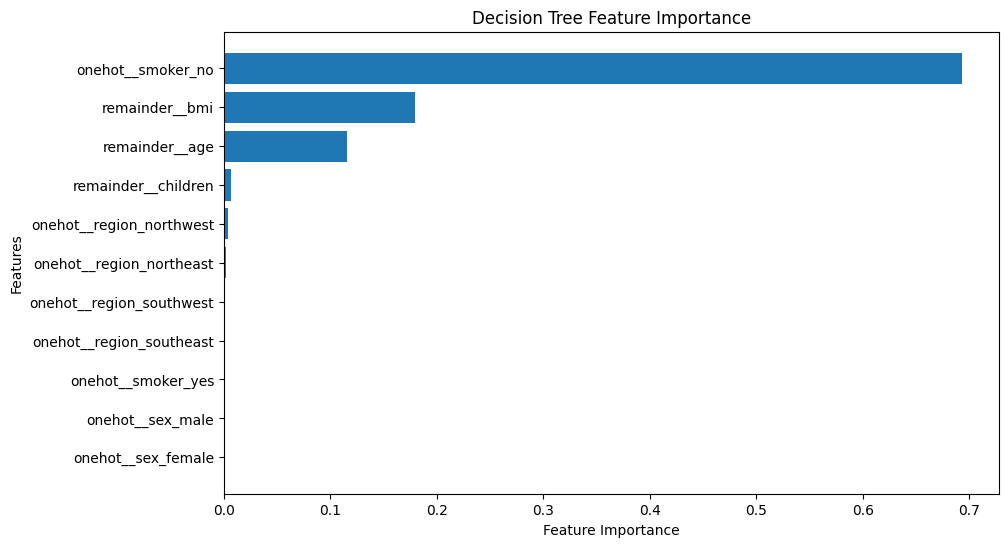

In [30]:
# Assuming 'tree' is your trained model and 'transformer' is your feature transformer
# Get feature importances
importances = tree.feature_importances_
feature_names = transformer.get_feature_names_out()

# Sort the feature importances and corresponding feature names
indices = np.argsort(importances)[::-1]
sorted_importances = importances[indices]
sorted_feature_names = feature_names[indices]

# Plot feature importances
plt.figure(figsize=(10, 6))
plt.barh(sorted_feature_names, sorted_importances)
plt.xlabel('Feature Importance')
plt.ylabel('Features')
plt.title('Decision Tree Feature Importance')
plt.gca().invert_yaxis()  # Invert y-axis to have the most important feature at the top
plt.show()

# Step 7: Random Forest

In [42]:
# Initialize Random Forest model
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)  # Adjust hyperparameters as needed

# Train the model
rf_model.fit(X_train, y_train)

# Predict on train and test data
y_pred_train = rf_model.predict(X_train)
y_pred_test = rf_model.predict(X_test)

In [43]:
# Evaluate model performance on training data
mse_train = mean_squared_error(y_train, y_pred_train)
rmse_train = mean_squared_error(y_train, y_pred_train, squared=False)
mae_train = mean_absolute_error(y_train, y_pred_train)
r2_train = r2_score(y_train, y_pred_train)

print('Training Metrics:')
print('RMSE:', rmse_train)
print('MAE:', mae_train)
print('R^2:', r2_train)

# Evaluate model performance on testing data
rmse_test = mean_squared_error(y_test, y_pred_test, squared=False)
mae_test = mean_absolute_error(y_test, y_pred_test)
r2_test = r2_score(y_test, y_pred_test)

print('\nTesting Metrics:')
print('RMSE:', rmse_test)
print('MAE:', mae_test)
print('R^2:', r2_test)

Training Metrics:
RMSE: 1911.1746477918875
MAE: 1045.1401466105851
R^2: 0.9746934325804264

Testing Metrics:
RMSE: 4590.47276006361
MAE: 2545.27659835908
R^2: 0.8642665871830159


Selected Features: ['onehot__smoker_no', 'remainder__bmi', 'onehot__smoker_yes', 'remainder__age', 'remainder__children']


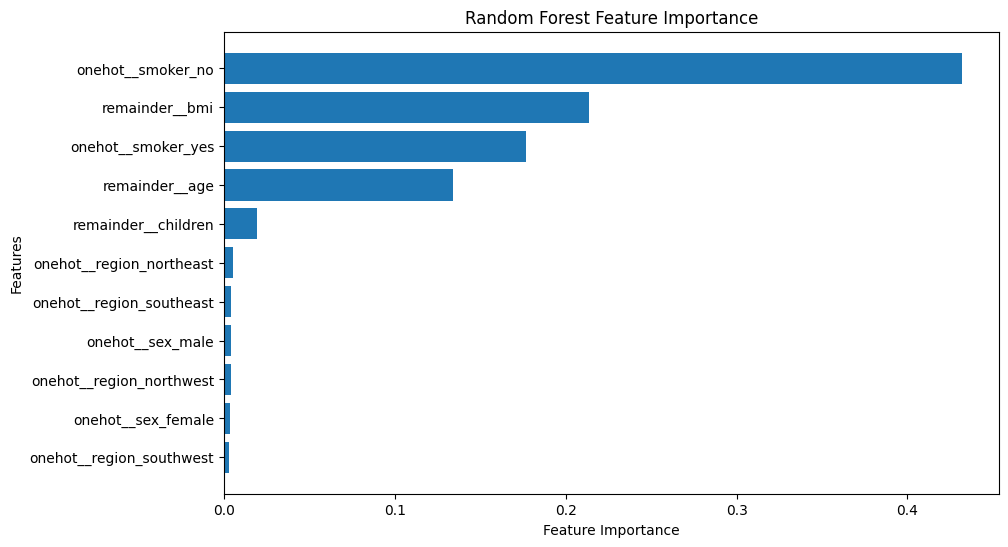

In [47]:
import pandas as pd
import matplotlib.pyplot as plt

# Use get_feature_names_out() to get names of transformed features
feature_names = transformer.get_feature_names_out()

# Get feature importances from the trained Random Forest model
importances = rf_model.feature_importances_

# Create DataFrame with feature importances
feature_importances = pd.DataFrame({'Feature': feature_names, 'Importance': importances})

# Sort the DataFrame by importance
feature_importances = feature_importances.sort_values(by='Importance', ascending=False).reset_index(drop=True)

# Select top k features (adjust k as needed)
k = 5  # Example: select top 5 features
selected_features = feature_importances['Feature'][:k].tolist()

# Print the selected features
print("Selected Features:", selected_features)

# Plot feature importances
plt.figure(figsize=(10, 6))
plt.barh(feature_importances['Feature'], feature_importances['Importance'])
plt.xlabel('Feature Importance')
plt.ylabel('Features')
plt.title('Random Forest Feature Importance')
plt.gca().invert_yaxis()  # Invert y-axis to have the most important feature at the top
plt.show()

# Step 8: Feature Interpretation and more Data Visualization

* The decision tree shows the feature relationship with the 
* The very fact that bmi $\geq 29.97$ and $< 29.97$ is coming out to be an important feature for decision making, while [2] shows that 29.9/30.00 onwards, it falls in obese range is quite interesting.


[[2]](https://www.cdc.gov/healthyweight/assessing/index.html#:~:text=If%20your%20BMI%20is%20less,falls%20within%20the%20obese%20range.): If your BMI is less than 18.5, it falls within the underweight range.
If your BMI is 18.5 to 24.9, it falls within the Healthy Weight range.
If your BMI is 25.0 to 29.9, it falls within the overweight range.
If your BMI is 30.0 or higher, it falls within the obese range.

In [71]:
# Create a new column 'bmi_status'
df['bmi_status'] = df['bmi'].apply(lambda x: 'high' if x >= 29.97 else 'low')

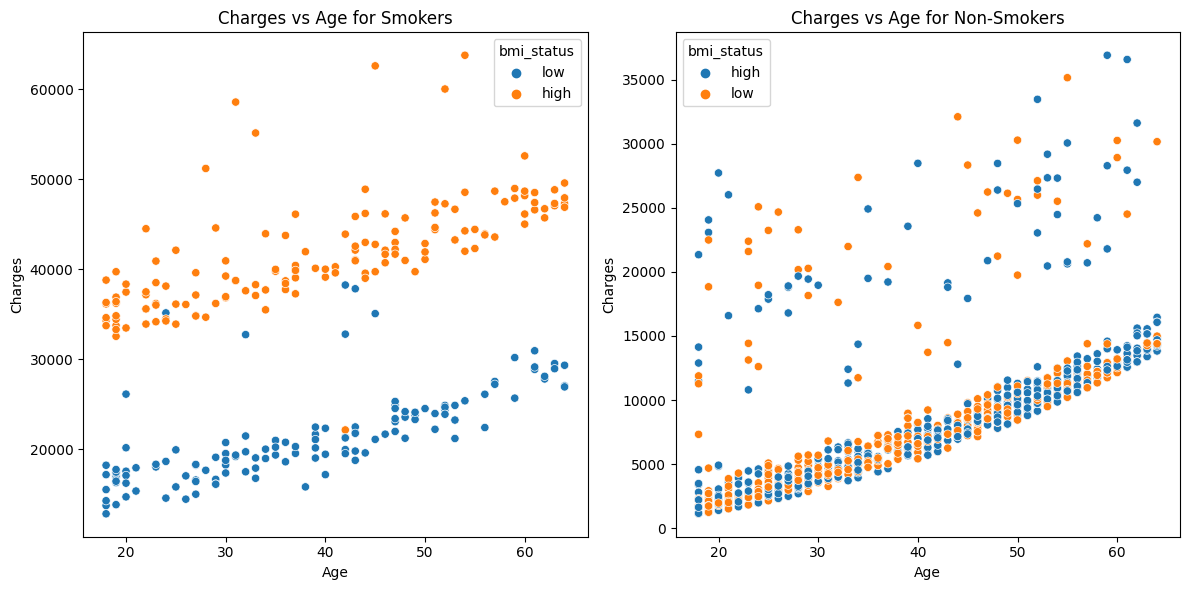

In [55]:
# Filter data for smokers and non-smokers
smokers_df = df[df['smoker'] == 'yes']
non_smokers_df = df[df['smoker'] == 'no']

# Create subplots
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Plot for smokers
sns.scatterplot(x='age', y='charges', hue='bmi_status', data=smokers_df, ax=axes[0])
axes[0].set_title('Charges vs Age for Smokers')
axes[0].set_xlabel('Age')
axes[0].set_ylabel('Charges')

# Plot for non-smokers
sns.scatterplot(x='age', y='charges', hue='bmi_status', data=non_smokers_df, ax=axes[1])
axes[1].set_title('Charges vs Age for Non-Smokers')
axes[1].set_xlabel('Age')
axes[1].set_ylabel('Charges')

plt.tight_layout()
plt.show()

/tmp/ipykernel_33/512529848.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  non_smokers_df['cluster'] = gmm.fit_predict(X)


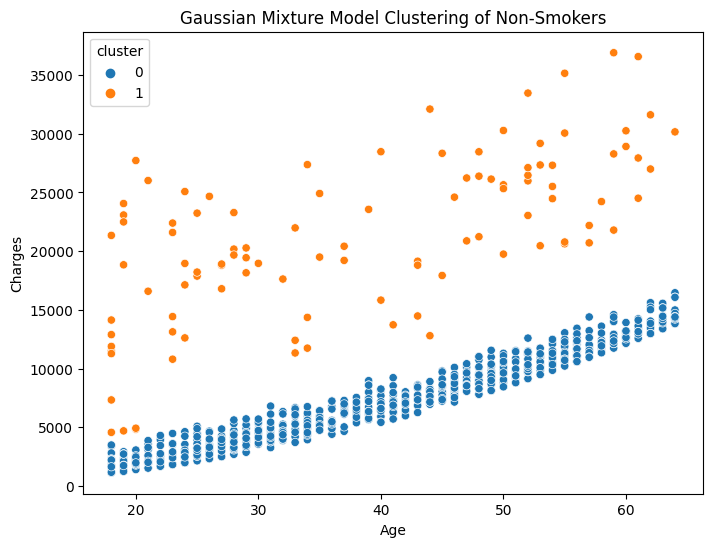

In [63]:
# Suppress the FutureWarning from modules
warnings.filterwarnings("ignore", category=FutureWarning, module="GaussianMixture")


# Select features for clustering (age and charges)
X = non_smokers_df[['age', 'charges']]

# Initialize GaussianMixture with 2 components
gmm = GaussianMixture(n_components=2, random_state=42)

# Fit the model and predict cluster labels
non_smokers_df['cluster'] = gmm.fit_predict(X)

# Visualize the clusters
plt.figure(figsize=(8, 6))
sns.scatterplot(x='age', y='charges', hue='cluster', data=non_smokers_df)
plt.title('Gaussian Mixture Model Clustering of Non-Smokers')
plt.xlabel('Age')
plt.ylabel('Charges')
plt.show()

/tmp/ipykernel_33/3850096588.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  non_smokers_df['cluster'] = gmm.fit_predict(X)
/tmp/ipykernel_33/3850096588.py:31: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['cluster'].fillna(-1, inplace=True)


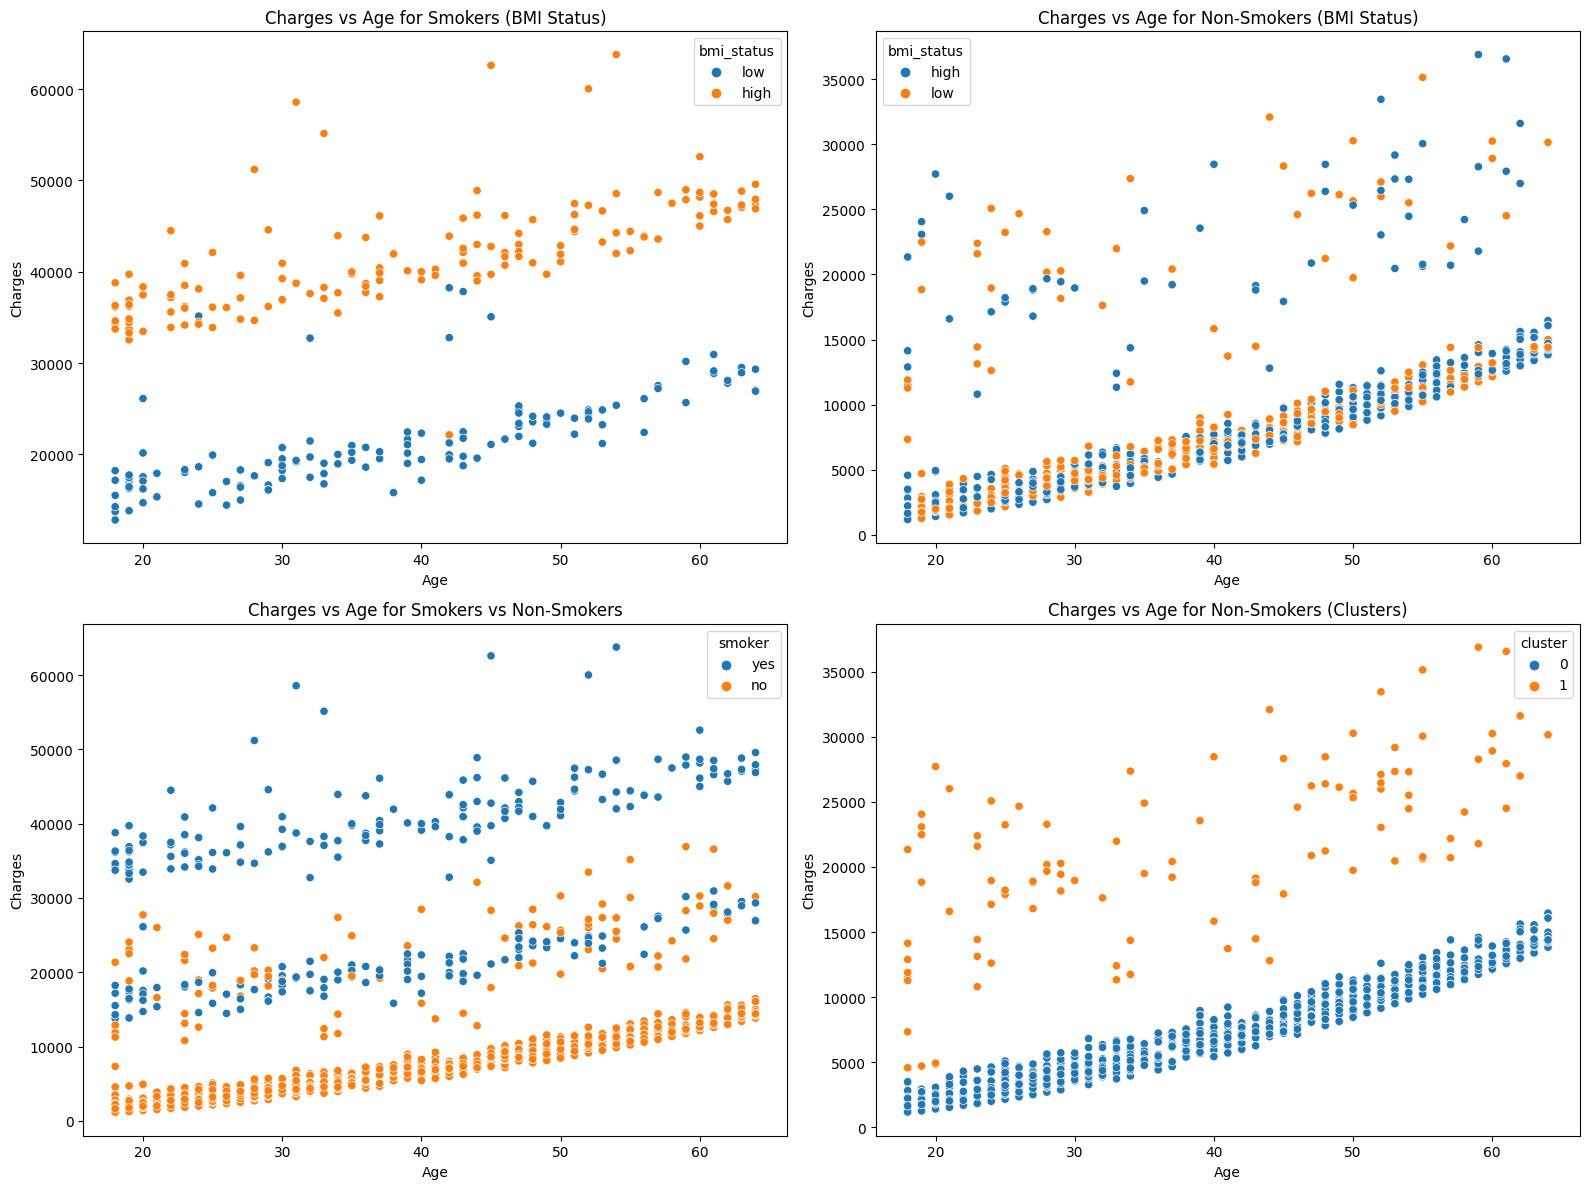

In [85]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.mixture import GaussianMixture

# Create a new column 'bmi_status'
df['bmi_status'] = df['bmi'].apply(lambda x: 'high' if x >= 29.97 else 'low')

# Filter data for smokers and non-smokers
smokers_df = df[df['smoker'] == 'yes']
non_smokers_df = df[df['smoker'] == 'no']

# Suppress the FutureWarning from modules
import warnings
warnings.filterwarnings("ignore", category=FutureWarning, module="GaussianMixture")

# Select features for clustering (age and charges)
X = non_smokers_df[['age', 'charges']]

# Initialize GaussianMixture with 2 components
gmm = GaussianMixture(n_components=2, random_state=42)

# Fit the model and predict cluster labels
non_smokers_df['cluster'] = gmm.fit_predict(X)

# Merge cluster info back into the main DataFrame
df = df.merge(non_smokers_df[['age', 'charges', 'cluster']], on=['age', 'charges'], how='left')

# Fill NaN values in the cluster column (for smokers) with a default cluster, e.g., -1
df['cluster'].fillna(-1, inplace=True)

# Create subplots
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Plot for smokers with BMI status
sns.scatterplot(x='age', y='charges', hue='bmi_status', data=smokers_df, ax=axes[0, 0])
axes[0, 0].set_title('Charges vs Age for Smokers (BMI Status)')
axes[0, 0].set_xlabel('Age')
axes[0, 0].set_ylabel('Charges')

# Plot for non-smokers with BMI status
sns.scatterplot(x='age', y='charges', hue='bmi_status', data=non_smokers_df, ax=axes[0, 1])
axes[0, 1].set_title('Charges vs Age for Non-Smokers (BMI Status)')
axes[0, 1].set_xlabel('Age')
axes[0, 1].set_ylabel('Charges')

# Plot for smokers
sns.scatterplot(x='age', y='charges', hue='smoker', data=df, ax=axes[1, 0])
axes[1, 0].set_title('Charges vs Age for Smokers vs Non-Smokers')
axes[1, 0].set_xlabel('Age')
axes[1, 0].set_ylabel('Charges')

# Plot for non-smokers with cluster
sns.scatterplot(x='age', y='charges', hue='cluster', data=non_smokers_df, ax=axes[1, 1])
axes[1, 1].set_title('Charges vs Age for Non-Smokers (Clusters)')
axes[1, 1].set_xlabel('Age')
axes[1, 1].set_ylabel('Charges')

plt.tight_layout()
plt.show()

/tmp/ipykernel_33/3773018254.py:5: UserWarning: The markers list has more values (2) than needed (1), which may not be intended.
  sns.scatterplot(x='age', y='charges', data=df[(df['smoker'] == 'yes') & (df['bmi_status'] == 'high')],
/tmp/ipykernel_33/3773018254.py:9: UserWarning: The markers list has more values (2) than needed (1), which may not be intended.
  sns.scatterplot(x='age', y='charges', data=df[(df['smoker'] == 'yes') & (df['bmi_status'] == 'low')],


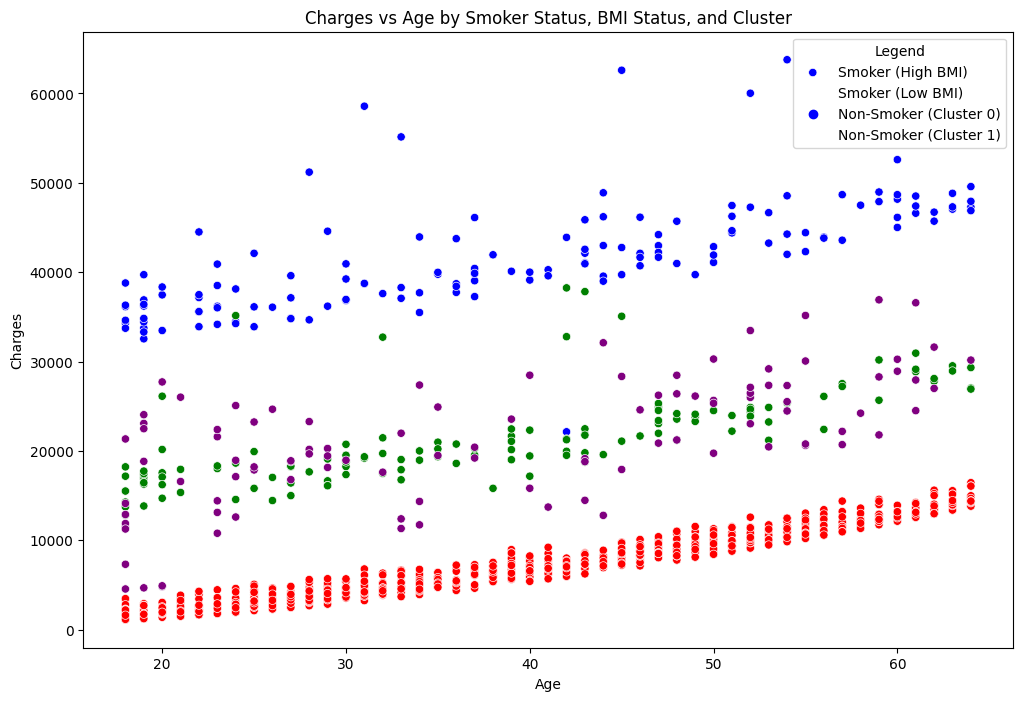

In [89]:
# Create a single plot with different categories using distinct colors
plt.figure(figsize=(12, 8))

# Plot for smoker with high BMI (blue)
sns.scatterplot(x='age', y='charges', data=df[(df['smoker'] == 'yes') & (df['bmi_status'] == 'high')], 
                hue='smoker', style='bmi_status', markers=['o', 's'], palette=['blue'], legend='full')

# Plot for smoker with low BMI (red)
sns.scatterplot(x='age', y='charges', data=df[(df['smoker'] == 'yes') & (df['bmi_status'] == 'low')], 
                hue='smoker', style='bmi_status', markers=['o', 's'], palette=['green'], legend=False)

# Plot for non-smokers with cluster 0 (green)
sns.scatterplot(x='age', y='charges', data=df[(df['smoker'] == 'no') & (df['cluster'] == 0)], 
                hue='cluster', palette=['red'], legend=False)

# Plot for non-smokers with cluster 1 (purple)
sns.scatterplot(x='age', y='charges', data=df[(df['smoker'] == 'no') & (df['cluster'] == 1)], 
                hue='cluster', palette=['purple'], legend=False)

plt.title('Charges vs Age by Smoker Status, BMI Status, and Cluster')
plt.xlabel('Age')
plt.ylabel('Charges')
plt.legend(title='Legend', loc='upper right', labels=['Smoker (High BMI)', 'Smoker (Low BMI)', 'Non-Smoker (Cluster 0)', 'Non-Smoker (Cluster 1)'])
plt.show()

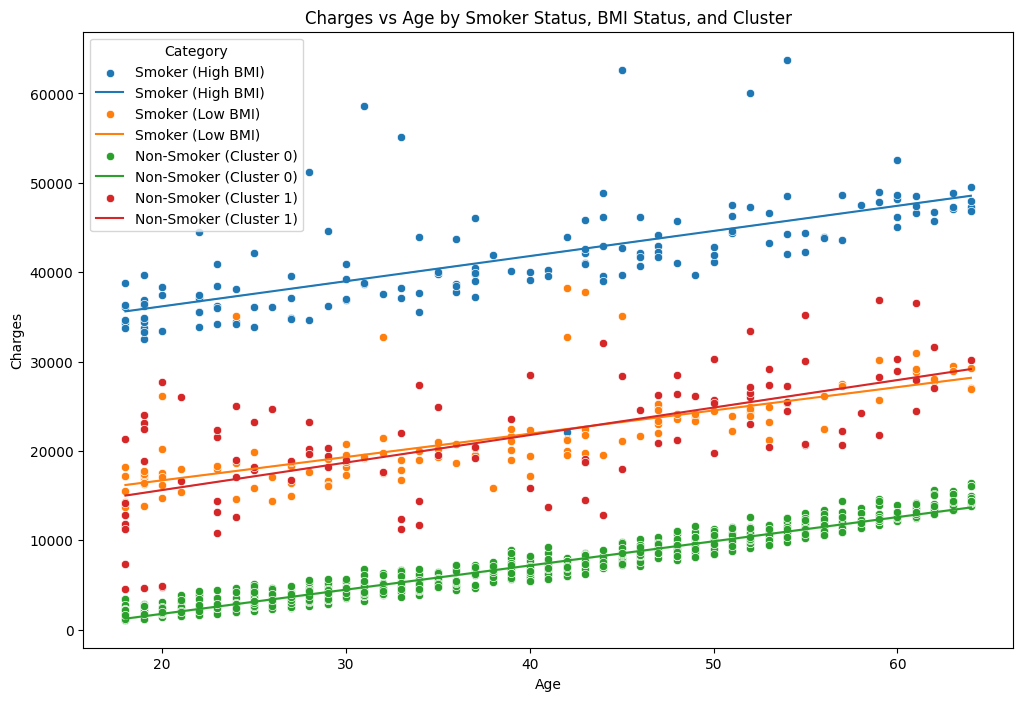

In [93]:
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
import seaborn as sns

# Initialize Linear Regression models
models = {
    'Smoker (High BMI)': LinearRegression(),
    'Smoker (Low BMI)': LinearRegression(),
    'Non-Smoker (Cluster 0)': LinearRegression(),
    'Non-Smoker (Cluster 1)': LinearRegression()
}

# Subset data for each category
categories = {
    'Smoker (High BMI)': (df['smoker'] == 'yes') & (df['bmi_status'] == 'high'),
    'Smoker (Low BMI)': (df['smoker'] == 'yes') & (df['bmi_status'] == 'low'),
    'Non-Smoker (Cluster 0)': (df['smoker'] == 'no') & (df['cluster'] == 0),
    'Non-Smoker (Cluster 1)': (df['smoker'] == 'no') & (df['cluster'] == 1)
}

# Create the plot
plt.figure(figsize=(12, 8))

# Plot all categories on the same plot
for category, condition in categories.items():
    X_category = df.loc[condition, ['age']]
    y_category = df.loc[condition, 'charges']
    
    model = models[category]
    model.fit(X_category, y_category)
    
    # Predict charges
    y_pred = model.predict(X_category)
    
    # Plot data points
    sns.scatterplot(x='age', y='charges', data=df[condition], label=category, marker='o')

    # Plot regression line
    sns.lineplot(x=X_category['age'], y=y_pred, label=category)

plt.title('Charges vs Age by Smoker Status, BMI Status, and Cluster')
plt.xlabel('Age')
plt.ylabel('Charges')
plt.legend(title='Category')
plt.show()

In [103]:
from sklearn.metrics import mean_absolute_error

# Function to fit linear regression model and minimize MAE
def fit_linear_regression_min_mae(X, y):
    # Standardize age
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X.values.reshape(-1, 1))

    # Initialize and fit model
    model = LinearRegression()
    model.fit(X_scaled, y)

    # Predict and calculate MAE
    y_pred = model.predict(X_scaled)
    mae = mean_absolute_error(y, y_pred)
    
    return model, scaler, mae

# Fit models for each group using X_train and y_train
models = {}
scalers = {}

# Fit model for smokers with high BMI
models['smokers_high_bmi'], scalers['smokers_high_bmi'], _ = fit_linear_regression_min_mae(
    smokers_high_bmi['age'], smokers_high_bmi['charges'])

# Fit model for non-smokers in cluster 0
models['non_smokers_cluster_0'], scalers['non_smokers_cluster_0'], _ = fit_linear_regression_min_mae(
    non_smokers_cluster_0['age'], non_smokers_cluster_0['charges'])

# Fit model for non-smokers in cluster 1
models['non_smokers_cluster_1'], scalers['non_smokers_cluster_1'], _ = fit_linear_regression_min_mae(
    non_smokers_cluster_1['age'], non_smokers_cluster_1['charges'])

# Function to predict charges based on new data
def predict_charges(model, scaler, age):
    # Scale age and predict
    age_scaled = scaler.transform(np.array([[age]]))
    return model.predict(age_scaled)[0]

# Predict charges on X_test
y_pred_test = []
for i in range(len(X_test)):
    row = X_test[i]  # Access row by index
    
    if row[1] == 'yes' and row[2] == 'high':  # Assuming 'smoker' is the second column, 'bmi_status' is the third column
        predicted_charge = predict_charges({
            'age': row[0],  # Assuming 'age' is the first column
            'smoker': 'yes',
            'bmi_status': 'high',
            'charges': row[3]  # Assuming 'charges' is the fourth column
        })
    elif row[1] == 'yes' and row[2] == 'low':  # Assuming 'smoker' is the second column, 'bmi_status' is the third column
        predicted_charge = predict_charges({
            'age': row[0],  # Assuming 'age' is the first column
            'smoker': 'yes',
            'bmi_status': 'low',
            'charges': row[3]  # Assuming 'charges' is the fourth column
        })
    elif row[1] == 'no':
        # Determine cluster using Gaussian Mixture Model
        X_new_clustering = np.array([[row[0], row[3]]])  # Assuming 'age' is the first column, 'charges' is the fourth column
        cluster = gmm.predict(X_new_clustering)[0]
        group = f'non_smokers_cluster_{cluster}'
        predicted_charge = predict_charges({
            'age': row[0],  # Assuming 'age' is the first column
            'smoker': 'no',
            'bmi_status': None,  # No BMI status needed for non-smokers
            'charges': row[3]  # Assuming 'charges' is the fourth column
        })
    else:
        raise ValueError("Unexpected data group")

    y_pred_test.append(predicted_charge)

# Evaluate predictions on X_test against y_test
mae_test = mean_absolute_error(y_test, y_pred_test)
print(f'MAE on X_test: {mae_test}')

ValueError: Unexpected data group

In [69]:
cluster_1_df = non_smokers_df[non_smokers_df['cluster'] == 1]

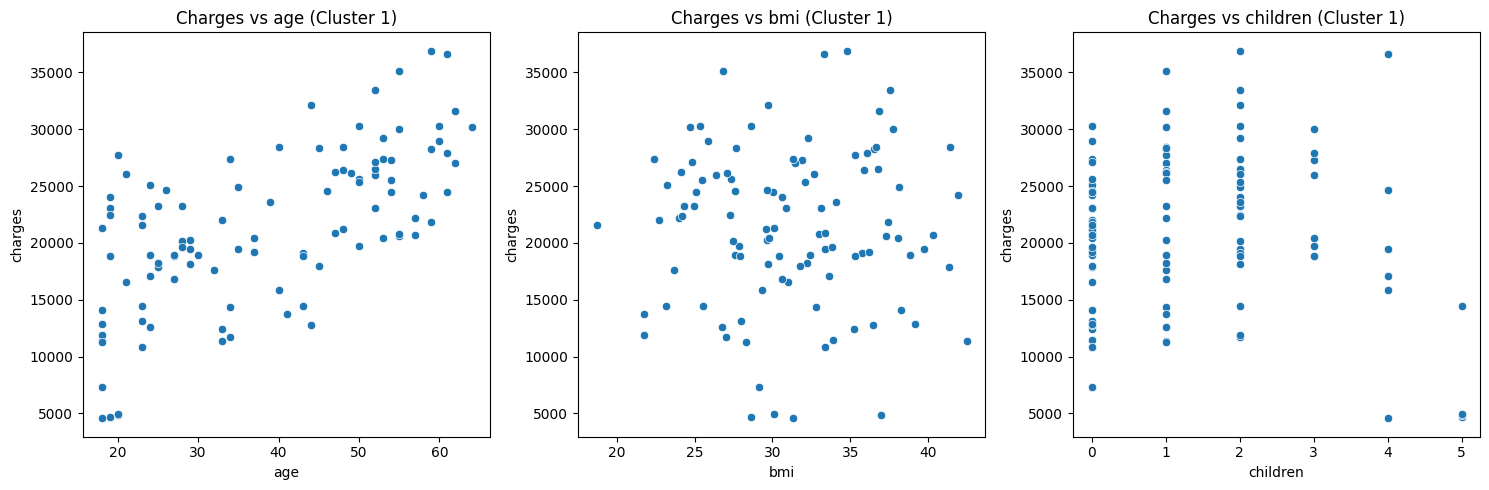

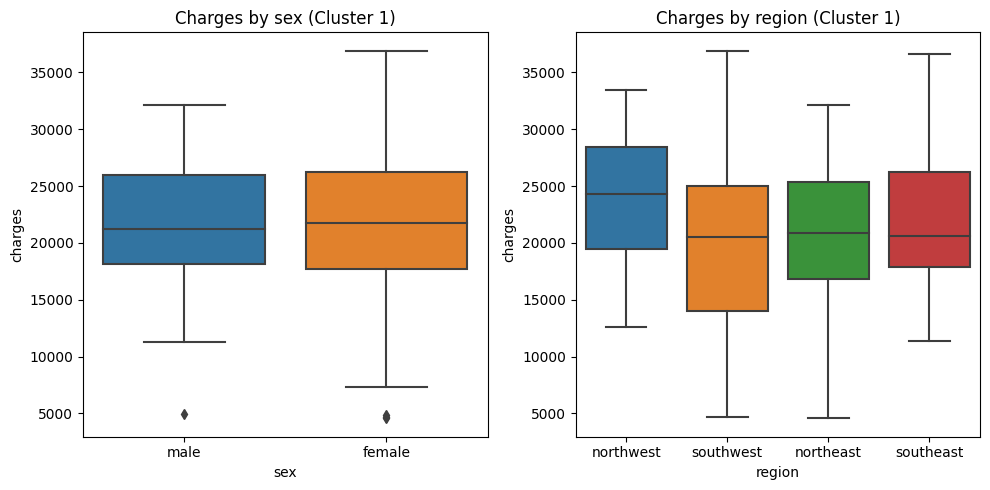

In [70]:
import matplotlib.pyplot as plt
import seaborn as sns

# Numerical features
numerical_features = ['age', 'bmi', 'children']

# Categorical features
categorical_features = ['sex', 'region']  # 'smoker' is excluded as it's all 'no'

# Create subplots for numerical features
fig, axes = plt.subplots(1, len(numerical_features), figsize=(15, 5))
for i, feature in enumerate(numerical_features):
    sns.scatterplot(x=feature, y='charges', data=cluster_1_df, ax=axes[i])
    axes[i].set_title(f'Charges vs {feature} (Cluster 1)')
plt.tight_layout()
plt.show()

# Create subplots for categorical features
fig, axes = plt.subplots(1, len(categorical_features), figsize=(10, 5))
for i, feature in enumerate(categorical_features):
    sns.boxplot(x=feature, y='charges', data=cluster_1_df, ax=axes[i])
    axes[i].set_title(f'Charges by {feature} (Cluster 1)')
plt.tight_layout()
plt.show()

In [72]:
# Create a new column 'bmi_status'
df['bmi_status'] = df['bmi'].apply(lambda x: 'high' if x >= 29.97 else 'low')

# Filter data for non-smokers
non_smokers_df = df[df['smoker'] == 'no']

# Select features for clustering (age and charges)
X_clustering = non_smokers_df[['age', 'charges']]

# Initialize GaussianMixture with 2 components
gmm = GaussianMixture(n_components=2, random_state=42)

# Fit the model and predict cluster labels
non_smokers_df['cluster'] = gmm.fit_predict(X_clustering)

# Merge cluster info back into the main DataFrame
df = df.merge(non_smokers_df[['age', 'charges', 'cluster']], on=['age', 'charges'], how='left')

# Fill NaN values in the cluster column (for smokers) with a default cluster, e.g., -1
df['cluster'].fillna(-1, inplace=True)

/tmp/ipykernel_33/2367978138.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  non_smokers_df['cluster'] = gmm.fit_predict(X_clustering)
/tmp/ipykernel_33/2367978138.py:20: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['cluster'].fillna(-1, inplace=True)


In [74]:
# Define features and target
features = ['age', 'bmi_status', 'cluster']
target = 'charges'

# Split the data
X = df[features]
y = df[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [79]:
# Separate data into groups
smokers_high_bmi = df[(df['smoker'] == 'yes') & (df['bmi_status'] == 'high')]
non_smokers_cluster_0 = df[(df['smoker'] == 'no') & (df['cluster'] == 0)]
non_smokers_cluster_1 = df[(df['smoker'] == 'no') & (df['cluster'] == 1)]

# Initialize dictionaries to store models and results
models = {}
scalers = {}
results = {}

# Function to fit linear regression model and minimize MAE
def fit_linear_regression_min_mae(X, y):
    # Standardize age
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X.values.reshape(-1, 1))

    # Initialize and fit model
    model = LinearRegression()
    model.fit(X_scaled, y)

    # Predict and calculate MAE
    y_pred = model.predict(X_scaled)
    mae = mean_absolute_error(y, y_pred)
    
    return model, scaler, mae

# Fit models for each group
models['smokers_high_bmi'], scalers['smokers_high_bmi'], results['smokers_high_bmi'] = fit_linear_regression_min_mae(smokers_high_bmi['age'], smokers_high_bmi['charges'])
models['non_smokers_cluster_0'], scalers['non_smokers_cluster_0'], results['non_smokers_cluster_0'] = fit_linear_regression_min_mae(non_smokers_cluster_0['age'], non_smokers_cluster_0['charges'])
models['non_smokers_cluster_1'], scalers['non_smokers_cluster_1'], results['non_smokers_cluster_1'] = fit_linear_regression_min_mae(non_smokers_cluster_1['age'], non_smokers_cluster_1['charges'])

# Print results
for key in results:
    print(f'{key} MAE: {results[key]}')

# Function to predict charges based on new data
def predict_charges(new_data):
    if new_data['smoker'] == 'yes' and new_data['bmi_status'] == 'high':
        group = 'smokers_high_bmi'
    elif new_data['smoker'] == 'no':
        X_new_clustering = np.array([[new_data['age'], new_data['charges']]])
        cluster = gmm.predict(X_new_clustering)[0]
        group = f'non_smokers_cluster_{cluster}'
    else:
        raise ValueError("Unexpected data group")
    
    # Scale age and predict
    age_scaled = scalers[group].transform(np.array([[new_data['age']]]))
    return models[group].predict(age_scaled)[0]

# Example new test data
new_test_data = {'age': 45, 'smoker': 'no', 'bmi_status': 'low', 'charges': 3000}
predicted_charge = predict_charges(new_test_data)
print(f'Predicted Charge: {predicted_charge}')

smokers_high_bmi MAE: 2740.007320592396
non_smokers_cluster_0 MAE: 638.1596664043292
non_smokers_cluster_1 MAE: 4231.629283288532
Predicted Charge: 23317.962200770024


/opt/conda/lib/python3.10/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but GaussianMixture was fitted with feature names
  warnings.warn(


In [80]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Function to predict charges based on the group
def predict_charges(new_data):
    if new_data['smoker'] == 'yes' and new_data['bmi_status'] == 'high':
        group = 'smokers_high_bmi'
    elif new_data['smoker'] == 'no':
        X_new_clustering = np.array([[new_data['age'], new_data['charges']]])
        cluster = gmm.predict(X_new_clustering)[0]
        group = f'non_smokers_cluster_{cluster}'
    else:
        raise ValueError("Unexpected data group")
    
    # Scale age and predict
    age_scaled = scalers[group].transform(np.array([[new_data['age']]]))
    return models[group].predict(age_scaled)[0]

# Make predictions on X_test
y_pred = []

for index, row in X_test.iterrows():
    new_data = {
        'age': row['age'],
        'smoker': df.loc[index, 'smoker'],
        'bmi_status': row['bmi_status'],
        'charges': y_test.loc[index]
    }
    y_pred.append(predict_charges(new_data))

# Convert predictions to a numpy array
y_pred = np.array(y_pred)

# Evaluate model performance
mae = mean_absolute_error(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred, squared=False)
r2 = r2_score(y_test, y_pred)

print(f'Mean Absolute Error: {mae}')
print(f'Root Mean Squared Error: {rmse}')
print(f'R^2 Score: {r2}')

/opt/conda/lib/python3.10/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but GaussianMixture was fitted with feature names
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but GaussianMixture was fitted with feature names
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but GaussianMixture was fitted with feature names
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but GaussianMixture was fitted with feature names
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but GaussianMixture was fitted with feature names
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names,

ValueError: Unexpected data group